In [50]:
import pickle
import pandas as pd
import gzip
import os
import mne

from sklearn.decomposition import FastICA, PCA
from sklearn.preprocessing import MinMaxScaler
import mne
import os
import matplotlib
from tensorflow import keras
import natsort
import numpy as np
from sklearn.decomposition import PCA

In [51]:
filepath = []
for (path, dir, files) in os.walk("E:\MDD_BDI"):
    for filename in files:
        ext = os.path.splitext(filename)[-1]
        if ext == '.set':
            filepath.append("%s\%s" % (path, filename))

In [52]:
Prob_file = []
for file in filepath:
    if "Proba" in file:
        Prob_file.append(file)
Prob_file[:10]

['E:\\MDD_BDI\\sub-001\\eeg\\sub-001_task-ProbabilisticSelection_eeg.set',
 'E:\\MDD_BDI\\sub-002\\eeg\\sub-002_task-ProbabilisticSelection_eeg.set',
 'E:\\MDD_BDI\\sub-003\\eeg\\sub-003_task-ProbabilisticSelection_eeg.set',
 'E:\\MDD_BDI\\sub-004\\eeg\\sub-004_task-ProbabilisticSelection_eeg.set',
 'E:\\MDD_BDI\\sub-005\\eeg\\sub-005_task-ProbabilisticSelection_eeg.set',
 'E:\\MDD_BDI\\sub-006\\eeg\\sub-006_task-ProbabilisticSelection_eeg.set',
 'E:\\MDD_BDI\\sub-007\\eeg\\sub-007_task-ProbabilisticSelection_eeg.set',
 'E:\\MDD_BDI\\sub-008\\eeg\\sub-008_task-ProbabilisticSelection_eeg.set',
 'E:\\MDD_BDI\\sub-009\\eeg\\sub-009_task-ProbabilisticSelection_eeg.set',
 'E:\\MDD_BDI\\sub-010\\eeg\\sub-010_task-ProbabilisticSelection_eeg.set']

In [53]:
channels = ['FP1', 'FP2',
 'F7', 'F3', 'FZ', 'F4', 'F8',
 'T7', 'C3', 'CZ', 'C4', 'T8',
 'P7', 'P3', 'PZ', 'P4', 'P8',
 'O1', 'O2',
]

In [54]:
seg_unit = 512 * 10

In [55]:
"""
y = []
dataframes = []
for i in range(len(Prob_file)):
    temp = mne.io.read_raw_eeglab(Prob_file[i])
    temp = temp.to_data_frame()
    temp = temp[channels]

    MinMax = MinMaxScaler()
    X = MinMax.fit_transform(temp)

    ica = FastICA()
    S_ = ica.fit_transform(X)
    for k in range(50):
        sliced_data = S_[k*seg_unit : (k+1)*seg_unit]

        dataframes.append(pd.DataFrame(sliced_data, columns=channels))
"""

'\ny = []\ndataframes = []\nfor i in range(len(Prob_file)):\n    temp = mne.io.read_raw_eeglab(Prob_file[i])\n    temp = temp.to_data_frame()\n    temp = temp[channels]\n\n    MinMax = MinMaxScaler()\n    X = MinMax.fit_transform(temp)\n\n    ica = FastICA()\n    S_ = ica.fit_transform(X)\n    for k in range(50):\n        sliced_data = S_[k*seg_unit : (k+1)*seg_unit]\n\n        dataframes.append(pd.DataFrame(sliced_data, columns=channels))\n'

In [56]:
with gzip.open('data10sec.pickle','rb') as f:
    dataframes = pickle.load(f)

with gzip.open('C:\ARK\eeg\EEG_BDI\y10sec.pickle','rb') as f:
    y = pickle.load(f)

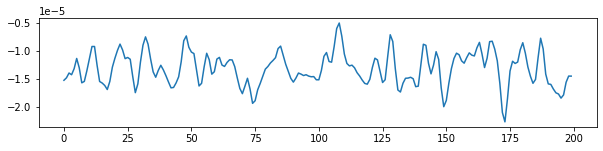

In [57]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,2))
temp = dataframes[0]
plt.plot(temp['FP1'][:200])

In [58]:
len(dataframes), len(y)
new_x = []
new_y = []
for i in range(len(dataframes)):
    if len(dataframes[i]) == 5120:
        new_x.append(dataframes[i])
        new_y.append(y[i])

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_x, new_y, test_size=0.2, random_state = 1)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

np.nan_to_num(y_train, copy=False)
np.nan_to_num(y_test, copy=False)



print(X_train.shape)
print(y_train.shape)
print(X_test.shape)


(4879, 5120, 19)
(4879,)
(1220, 5120, 19)


In [60]:
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, Dense, Flatten, Dropout, BatchNormalization, Reshape, LeakyReLU, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
import os



In [61]:
from tensorflow.keras import layers
model = keras.Sequential(
    [
        layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 2560, 32)          4288      
_________________________________________________________________
dropout_2 (Dropout)          (None, 2560, 32)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1280, 16)          3600      
_________________________________________________________________
conv1d_transpose_3 (Conv1DTr (None, 2560, 16)          1808      
_________________________________________________________________
dropout_3 (Dropout)          (None, 2560, 16)          0         
_________________________________________________________________
conv1d_transpose_4 (Conv1DTr (None, 5120, 32)          3616      
_________________________________________________________________
conv1d_transpose_5 (Conv1DTr (None, 5120, 1)         

In [62]:
history = model.fit(
    X_train,
    X_train,
    epochs=50,
    batch_size=64,
    validation_split=0.1
)

Epoch 1/50
69/69 [==============================] - 10s 117ms/step - loss: 1.9484e-06 - val_loss: 1.0103e-06

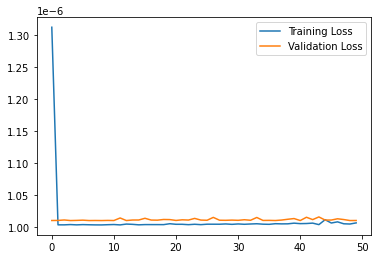

In [63]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

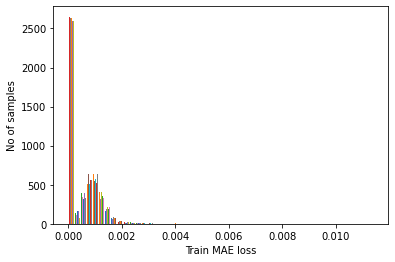

In [64]:
x_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(x_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

In [65]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

Reconstruction error threshold:  0.011423432467075273


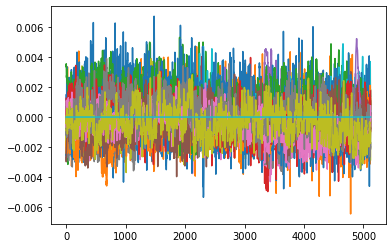

In [66]:
# Checking how the first sequence is learnt
plt.plot(X_train[0])
plt.plot(x_train_pred[0])
plt.show()

In [67]:
model.save("model")
model.summary()

INFO:tensorflow:Assets written to: model\assets
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 2560, 32)          4288      
_________________________________________________________________
dropout_2 (Dropout)          (None, 2560, 32)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1280, 16)          3600      
_________________________________________________________________
conv1d_transpose_3 (Conv1DTr (None, 2560, 16)          1808      
_________________________________________________________________
dropout_3 (Dropout)          (None, 2560, 16)          0         
_________________________________________________________________
conv1d_transpose_4 (Conv1DTr (None, 5120, 32)          3616      
_________________________________________________________________
conv1

In [68]:
newmodel = Sequential()
newmodel.add(layers.Input(shape=(X_train.shape[1], X_train.shape[2])))
for i, layer in enumerate(model.layers):
    if i < 3 :
        print(layer)
        newmodel.add(layer)

newmodel.add(layers.Flatten())
newmodel.add(layers.Dense(64, activation='relu'))
newmodel.add(layers.Dense(1))

newmodel.build()
newmodel.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 2560, 32)          4288      
_________________________________________________________________
dropout_2 (Dropout)          (None, 2560, 32)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1280, 16)          3600      
_________________________________________________________________
flatten_5 (Flatten)          (None, 20480)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1310784   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 1,318,737
Trainable params: 1,318,737
Non-trainable params: 0
___________________________________________

In [69]:
from tensorflow.keras.optimizers import Adam
newmodel.compile(optimizer=Adam(lr=0.001),
                    loss='mse',
                    metrics=['mae','mse'])

In [71]:
history = newmodel.fit(X_test, y_test, epochs=100, batch_size=128, verbose=1, validation_split = 0.2)
history_dict = history.history

Epoch 1/100
8/8 [==============================] - 2s 167ms/step - loss: 209.2739 - mae: 9.9084 - mse: 209.2739 - val_loss: 167.4805 - val_mae: 8.6750 - val_mse: 167.4805
Epoch 2/100
8/8 [==============================] - 0s 54ms/step - loss: 139.3992 - mae: 8.8412 - mse: 139.3992 - val_loss: 135.4485 - val_mae: 11.0730 - val_mse: 135.4485